# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-109A Introduction to Data Science


## Lab 2: Linear Regression and k-NN

**Harvard University**<br/>
**Summer 2021**<br/>
**Authors:** Kevin Rader, Arpit Panda, Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas, Chris Tanner, 

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Table of Contents

<ol start="0">
<li> Building a model with statsmodels and sklearn </li>
<li> Example: simple linear regression with automobile data </li>
<li> $k$-nearest neighbors</li>
<li> Polynomial Regression, and the Cab Data</li>
<li> Multiple regression and exploring the Football data </li>
</ol>

## Learning Goals
After this lab, you should be able to
- Feel comfortable with simple linear regression
- Feel comfortable with $k$ nearest neighbors
- Explain the difference between train/validation/test data and WHY we have each.
- Implement arbitrary multiple regression models in both SK-learn and Statsmodels.
- Interpret the coefficent estimates produced by each model, including transformed and dummy variables

In [2]:

# import the necessary libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd


import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pandas.plotting import scatter_matrix


import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns


from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


%matplotlib inline


<a class="anchor" id="fourth-bullet"></a>
## Part 0 - Concept Check Questions

Answer the following questions:

1. What does it mean for a model to be non-parametric vs. parametric?  Name one type of model for each.

*Parametric models define the statistical model $f$ mathematically (puts a mathematical structure on it) while a non-parametric model does not out structure on $f$, and thus there are no parameters/coefficients to be estimated or interpreted directly.  $k$-NN is non-parametric, linear regression is parametric*

2. How are neighbors chosen in $k$-NN?  How are predictions made?  How can this model be interpreted?  What happens when k = 1?  When k = n?

*Neighbors are chosen based on how far observations are away in the $X$ space (Euclidean distance if everything is numeric...including categorical variables is complicated).  Precictions are made by averaging all the $k$ closest neighbors.  This model should be interpreted through the prdiction curve.  When $k=1$, the training data will be predicted perfectly (if there are no ties in $x$).  When $k=n$, the model predicts all points the same with $\bar{y}$.*

3. Why is it called ordinary least squares (OLS) regression?

*Because the line's coefficients are estimated by minimizing the sum of (or mean) squares of how far the $y_i$ are from the line $\hat{y}_i$ (aka, MSE)*

4. What is the interpretation of $\hat{\beta}_1$ in a simple regression model?  In a multiple regression model?

*It is the associated change in $y$ for a 1-unit change in $x_1$, on average.  In simple regression, it does not matter how any other potential $x$-variables change.  In multiple regression, it is holding all other $x$-variables in the model constant.*

5. What is multicollinearity?  What happens when multicollinearity is present?  

*Multicollinearity is present when the predictors have correlation with one another (if correlation is perfect, then they are called 'linearly dependent').  This can lead to unstable coefficient estimates ($\hat{\beta}$), and overfitting.  It is also related to confounding (differences in $\beta$ estimates for one variable whether anohter variable is present or not in a model).*

6. What is polynomial regression used for?

*To model non-linear relationships.*

7. How does a multiple regression model for 2 predictors (one binary, the other quantitative) compare in interpretation when the interaction is included vs. is not included in the model.  How can we visualize this?

*The difference is when the interaction term is not present, the relationship for the numeric predictor with the response will be the same (the lines will be parrallel) for the two groups defined by the binary predictor.  The inetraction term allows this relationship to depend on which group an observation is in (the lines may not be parrallel).*

8. Why is one of the binary terms dropped out when modeling a categorical predictors?  What are the interpretations of the $\hat{\beta}_j$ in this model?

*To prevent perfect linear dependence among the predictors and the intercept (alternatively, the intercept can be dropped).  In all linear regression models, the intercept estimates the predicted $y$ when all the $x$'s in the model are zero.  Here: that is estimating the mean response for the reference group.  The other coefficients estimate the difference between each corresponding group's mean response in relation to the mean response of the reference group.*


<a class="anchor" id="fourth-bullet"></a>
## Part 1 - Simple Linear Regression with `statsmodels` and `sklearn`

Let's learn two `python` packages to do simple linear regression for us:
* [statsmodels](http://www.statsmodels.org/stable/regression.html) and 
* [scikit-learn (sklearn)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

Our goal  is to show how to implement simple linear regression with these packages.  

For the purposes of this lab, `statsmodels` and `sklearn` do the same thing.  More generally though, `statsmodels` tends to be easier for inference \[finding the values of the slope and intercept and dicussing uncertainty in those values\], whereas `sklearn` has machine-learning algorithms and is better for prediction \[guessing y values for a given x value\]. (Note that both packages make the same guesses, it's just a question of which activity they provide more support for.

**Note:** `statsmodels` and `sklearn` are different packages!  Unless we specify otherwise, you can use either one.

### Linear regression with a toy dataset
We first examine a toy problem, focusing our efforts on fitting a linear model to a small dataset with three observations.  Each observation consists of one predictor $x_i$ and one response $y_i$ for $i = 1, 2, 3$,

\begin{align*}
(x , y) = \{(x_1, y_1), (x_2, y_2), (x_3, y_3)\}.
\end{align*}

To be very concrete, let's set the values of the predictors and responses.

\begin{equation*}
(x , y) = \{(1, 2), (2, 2), (3, 4)\}
\end{equation*}

There is no line of the form $\beta_0 + \beta_1 x = y$ that passes through all three observations, since the data are not collinear. Thus our aim is to find the line that best fits these observations in the *least-squares sense*, as discussed in lecture.

<div class="exercise"><b>Q1.1</b></div>

* Make two numpy arrays out of this data, x_train and y_train
* Check the dimentions of these arrays
* Be sure to reshape input array to 2-D (`x.reshape(-1, 1)`) because this becomes important later!

In [3]:
#your code here
x_train = np.array([1, 2, 3])
y_train = np.array([2, 2, 4])
x_train = x_train.reshape(-1, 1)

Below is the code for `statsmodels`.  `Statsmodels` does not by default include the column of ones in the $X$ matrix, so we include it manually with `sm.add_constant`.

In [4]:
import statsmodels.api as sm

In [5]:
# create the X matrix by appending a column of ones to x_train
X = sm.add_constant(x_train)


# build the OLS model (ordinary least squares) from the training data
toyregr_sm = sm.OLS(y_train, X)

# do the fit and save regression info (parameters, etc) in results_sm
results_sm = toyregr_sm.fit()

# pull the beta parameters out from results_sm
beta0_sm = results_sm.params[0]
beta1_sm = results_sm.params[1]

print(f'The regression coef from statsmodels are: beta_0 = {beta0_sm:8.6f} and beta_1 = {beta1_sm:8.6f}')

The regression coef from statsmodels are: beta_0 = 0.666667 and beta_1 = 1.000000


Besides the beta parameters, `results_sm` contains a ton of other potentially useful information.

In [6]:
import warnings
warnings.filterwarnings('ignore')
print(results_sm.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     3.000
Date:                Fri, 02 Jul 2021   Prob (F-statistic):              0.333
Time:                        11:08:15   Log-Likelihood:                -2.0007
No. Observations:                   3   AIC:                             8.001
Df Residuals:                       1   BIC:                             6.199
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667      1.247      0.535      0.6

Now let's turn our attention to the `sklearn` library.

In [7]:
from sklearn import linear_model

In [8]:
# build the least squares model
toyregr = linear_model.LinearRegression()
# save regression info (parameters, etc) in results_skl
results = toyregr.fit(x_train, y_train)

# pull the beta parameters out from results_skl
beta0_skl = toyregr.intercept_
beta1_skl = toyregr.coef_[0]

print("The regression coefficients from the sklearn package are: beta_0 = {0:8.6f} and beta_1 = {1:8.6f}".format(beta0_skl, beta1_skl))

The regression coefficients from the sklearn package are: beta_0 = 0.666667 and beta_1 = 1.000000


<div class="exercise"><b>Q1.2</b></div>
Do the values of beta_0 and beta_1 seem reasonable?
Plot the training data using a scatter plot.
Plot the best fit line with beta0 and beta1 together with the training data.

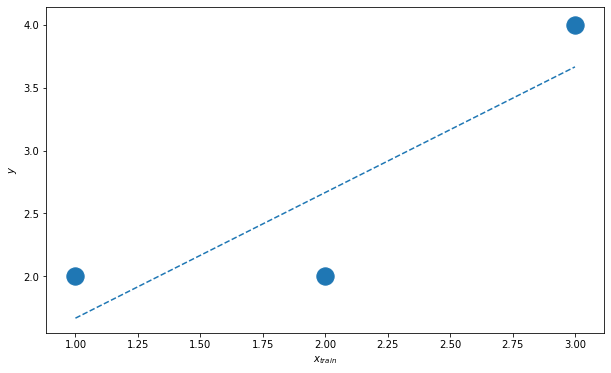

In [9]:
fig_scat, ax_scat = plt.subplots(1,1, figsize=(10,6))
beta_0 = beta0_skl
beta_1 = beta1_skl

# Plot best-fit line
x_train = np.array([[1, 2, 3]]).T

best_fit = beta_0 + beta_1 * x_train

ax_scat.scatter(x_train, y_train, s=300, label='Training Data')
ax_scat.plot(x_train, best_fit, ls='--', label='Best Fit Line')

ax_scat.set_xlabel(r'$x_{train}$')
ax_scat.set_ylabel(r'$y$');

We should feel pretty good about ourselves now, and we're ready to move on to a real problem!

### Let's use `scikit-learn`
Before diving right in to a "real" problem, we really ought to discuss more of the details of `sklearn`.  We do this now.  Along the way, we'll import the real-world dataset.

`Scikit-learn` is the main `python` machine learning library. It consists of many learners which can learn models from data, as well as a lot of utility functions such as `train_test_split`. It can be used in `python` by the incantation `import sklearn`.

In scikit-learn, an **estimator** is a Python object that implements the methods fit(X, y) and predict(T)

Let's see the structure of `scikit-learn` needed to make these fits. `.fit` always takes two arguments:
```python
  estimator.fit(Xtrain, ytrain)
```
We will consider two estimators in this lab: `LinearRegression` and `KNeighborsRegressor`.

Critically, `Xtrain` must be in the form of an *array of arrays* (or a 2x2 array) with the inner arrays each corresponding to one sample, and whose elements correspond to the feature values for that sample (visuals coming in a moment).

`ytrain` on the other hand is a simple array of responses.  These are continuous for regression problems.

![](images/sklearn2.jpg)

### Practice with `sklearn`
We begin by loading up the `mtcars` dataset and cleaning it up a little bit.

In [10]:
import pandas as pd

#load mtcars
dfcars = pd.read_csv("data/mtcars.csv")
dfcars = dfcars.rename(columns={"Unnamed: 0":"car name"})
dfcars.head()

,car name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


Next, let's split the dataset into a training set and test set.

In [11]:
# split into training set and testing set
from sklearn.model_selection import train_test_split

#set random_state to get the same split every time
traindf, testdf = train_test_split(dfcars, test_size=0.2, random_state=42)

In [12]:
# testing set is around 20% of the total data; training set is around 80%
print("Shape of full dataset is: {0}".format(dfcars.shape))
print("Shape of training dataset is: {0}".format(traindf.shape))
print("Shape of test dataset is: {0}".format(testdf.shape))

Shape of full dataset is: (32, 12)
Shape of training dataset is: (25, 12)
Shape of test dataset is: (7, 12)


Now we have training and test data.  We still need to select a predictor and a response from this dataset.  Keep in mind that we need to choose the predictor and response from both the training and test set.  You will do this in the exercises below.  However, we provide some starter code for you to get things going.

In [13]:
# Extract the response variable that we're interested in
y_train = traindf['mpg']

First, let's reshape y_train to be an array of arrays using the reshape method. We want the first dimension of y_train to be size  2525  and the second dimension to be size  11 .

In [14]:
#y_train_reshape = y_train.values.reshape(-1,1)
#y_train_reshape.shape

### Simple linear regression with automobile data
We will now use `sklearn` to predict automobile mileage per gallon (mpg) and evaluate these predictions. We already loaded the data and split them into a training set and a test set.

<div class="exercise"><b>Q1.2</b></div>
* Pick one variable to use as a predictor for simple linear regression.  Create a markdown cell below and discuss your reasons.  
* Justify your choice with some visualizations.  
* Is there a second variable you'd like to use? For example, we're not doing multiple linear regression here, but if we were, is there another variable you'd like to include if we were using two predictors?

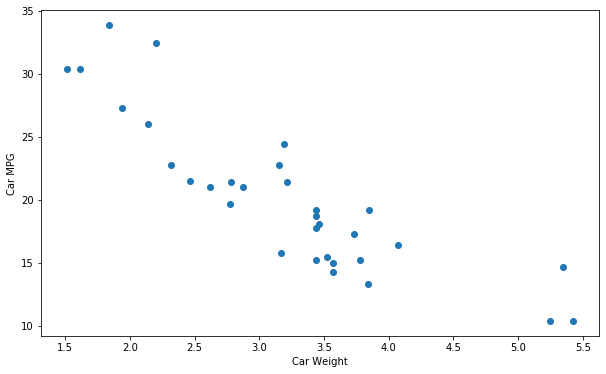

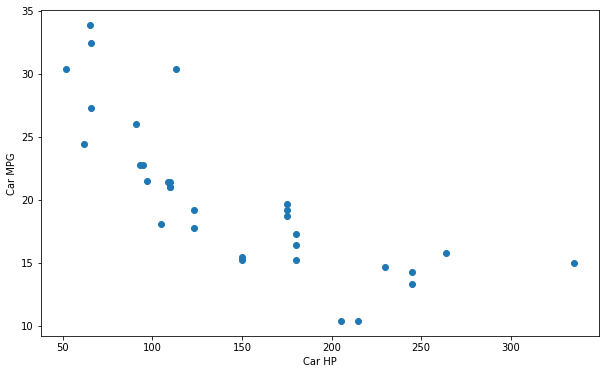

In [15]:
# Your code here
y_mpg = dfcars['mpg']
x_wt = dfcars[['wt']]
x_hp = dfcars[['hp']]

fig_wt, ax_wt = plt.subplots(1,1, figsize=(10,6))
ax_wt.scatter(x_wt, y_mpg)
ax_wt.set_xlabel(r'Car Weight')
ax_wt.set_ylabel(r'Car MPG')

fig_hp, ax_hp = plt.subplots(1,1, figsize=(10,6))
ax_hp.scatter(x_hp, y_mpg)
ax_hp.set_xlabel(r'Car HP')
ax_hp.set_ylabel(r'Car MPG')

plt.show()

Both weight and horsepower seem to have moderately (if not fully) strong negative relationships with fuel efficiency: larger automobiles and ones with more powerful engines have worse fuel efficiency.  It would be interesting to fit a multiple regression model with both predictors in to see if these associations are confounded with each other: do we really just need to use one of these predictors to build a reasonable model, or can adding the 2nd one add more interpretive and predictive power?

<div class="exercise"><b>Q1.3</b></div>

* Use `sklearn` to fit the training data using simple linear regression.
* Use the model to make mpg predictions on the test set.  

**Hints:**
* Use the following to perform the analysis:
```python
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
```

In [16]:
# Your code here
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

traindf, testdf = train_test_split(dfcars, test_size=0.2, random_state=42)

y_train = traindf['mpg']
X_train = traindf[['wt']]

In [17]:
y_test = testdf['mpg']
X_test = testdf[['wt']]

#create linear model
regression = LinearRegression()

#fit linear model
regression.fit(X_train, y_train)

predicted_y = regression.predict(X_test)

r2 = regression.score(X_test, y_test)
print(r2)

0.6879761857596272


<div class="exercise"><b>Q1.4</b></div>
* Plot the data and the prediction.  
* Print out the mean squared error for the training set and the test set and compare.

Text(0, 0.5, 'MPG')

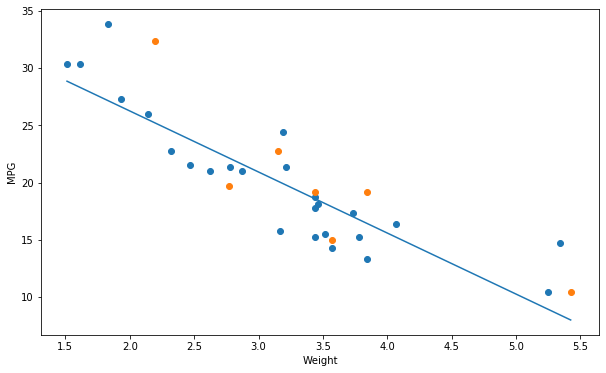

In [18]:
# Your code here
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(X_train,y_train)
ax.scatter(X_test, y_test)

xgrid = np.linspace(np.min(dfcars['wt']), np.max(dfcars['wt']), 100)
ygrid = regression.predict(xgrid.reshape(100,1))
ax.plot(xgrid, ygrid)

ax.set_xlabel("Weight")
ax.set_ylabel("MPG")

In [19]:
#Your data here
print(regression.score(X_train, y_train))

print(mean_squared_error(predicted_y, y_test))
print(mean_squared_error(y_train, regression.predict(X_train)))

print('Coefficients: \n', regression.coef_[0], regression.intercept_)

0.7701379909791617
12.475985659918837
7.773697766387512
Coefficients: 
 -5.336941400557081 36.93731031351841


MSE for the training set is 7.77 mpg$^2$ while it is much laeger in the test set: 12.48 mpg$^2$; this is not a surprising result as the linear regression model is fit to minimize this error on the data which was used to estimate the $\beta$ coefficients (possibly a little but of overfitting to the training set).

## Part 2 - $k$-nearest neighbors

Now that you're familiar with `sklearn`, you're ready to do a KNN regression.  

Sklearn's regressor is called `sklearn.neighbors.KNeighborsRegressor`. Its main parameter is the `number of nearest neighbors`. There are other parameters such as the distance metric (default for 2 order is the Euclidean distance). For a list of all the parameters see the [Sklearn kNN Regressor Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html).

Let's use $5$ nearest neighbors.

In [20]:
# Import the library
from sklearn.neighbors import KNeighborsRegressor

In [21]:
# Set number of neighbors
k = 5
knnreg = KNeighborsRegressor(n_neighbors=k)

<div class="exercise"><b>2.1</b></div>

Calculate the model's prediction on the test set and print the $R^{2}$ score 

In [22]:
# Your code here
# Fit the regressor - make sure your numpy arrays are the right shape
knnreg.fit(X_train, y_train)

# Evaluate the outcome on the train set using R^2
r2_train = knnreg.score(X_train, y_train)

# Print results
print(f'kNN model with {k} neighbors gives R^2 on the train set: {r2_train:.5}')

kNN model with 5 neighbors gives R^2 on the train set: 0.87181


Pretty good, but can we do better? Let's vary the number of neighbors and see what we get.

In [23]:
# Make our lives easy by storing the different regressors in a dictionary
knndict = {}

# Make our lives easier by entering the k values from a list
k_list = [1, 2, 3, 4, 10, 15]

# Do a bunch of KNN regressions
for k in k_list:
    knnreg = KNeighborsRegressor(n_neighbors=k)
    knnreg.fit(X_train, y_train)
    # Store the regressors in a dictionary
    knndict[k] = knnreg 

# Print the dictionary to see what we have
knndict

{1: KNeighborsRegressor(n_neighbors=1),
 2: KNeighborsRegressor(n_neighbors=2),
 3: KNeighborsRegressor(n_neighbors=3),
 4: KNeighborsRegressor(n_neighbors=4),
 10: KNeighborsRegressor(n_neighbors=10),
 15: KNeighborsRegressor(n_neighbors=15)}

Now let's plot all the predictions from using these $k$ values in the same plot.

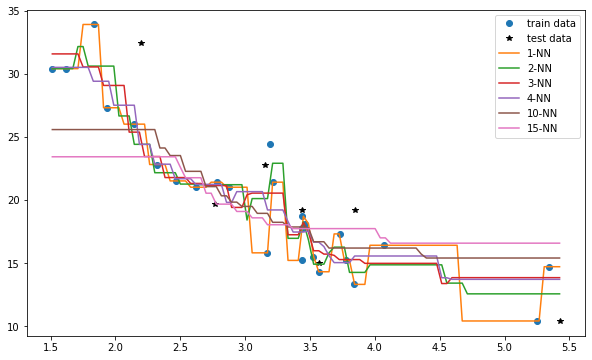

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

# scatter plots can be created with iether the scatter or plot functions (with an additional argument)
ax.plot(X_train, y_train, 'o', label="train data")
ax.plot(X_test, y_test, '*', label="test data", c = "black")

xgrid = np.linspace(np.min(dfcars['wt']), np.max(dfcars['wt']), 100).reshape(100,1)

# let's unpack the dictionary to its elements (items) which is the k and Regressor
for k, model in knndict.items():
    predictions = model.predict(xgrid) 
    ax.plot(xgrid, predictions, label="{}-NN".format(k))

ax.legend();

<div class="exercise"><b>2.2</b></div>

Explain what you see in the graph. **Hint** Notice how the $1$-NN goes through nearly every point on the training set but utterly fails elsewhere. 

*Your explanation*

The 1-NN is way too *jumpy* (too complex) to be useful for out-of-sample prediction (for example, it would be unexpected that estimated mpg should jump up from 10 to 14 at the highest weights (around 5.2)).  The 15-NN is likely too smooth (too simple a model) as the predicted values are quite flat at the extremes.  Most likely 4-NN would be the best model to predict out-of-sample as it describes the signal (general trend) from the noise (jumpiness) the best.

Lets look at the scores on the training set.

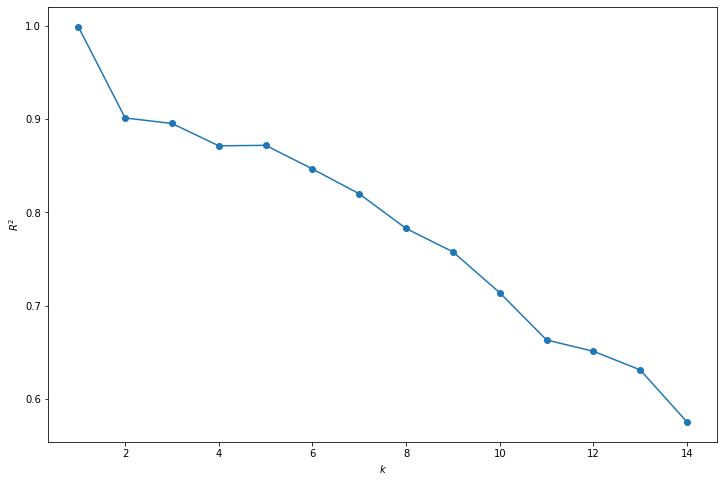

In [25]:
ks = range(1, 15) # Grid of k's
scores_train = [] # R2 scores
for k in ks:
    # Create KNN model
    knnreg = KNeighborsRegressor(n_neighbors=k) 
    
    # Fit the model to training data
    knnreg.fit(X_train, y_train) 
    
    # Calculate R^2 score
    score_train = knnreg.score(X_train, y_train) 
    scores_train.append(score_train)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(ks, scores_train,'o-')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$R^{2}$')
plt.show()

<div class="exercise"><b>2.3</div>

* Why do we get a perfect $R^2$ at k=1 for the training set?
* Make the same plot as above on the *test* set.
* What is the best $k$?

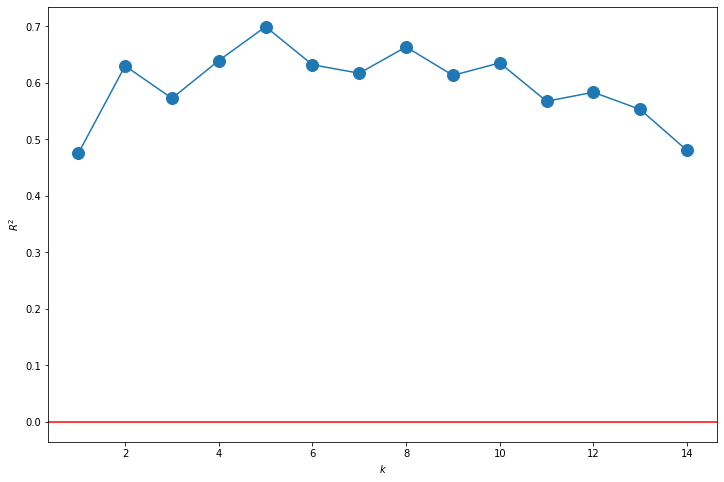

In [26]:
#Your code here
ks = range(1, 15) # Grid of k's
scores_test = [] # R2 scores
for k in ks:
    knnreg = KNeighborsRegressor(n_neighbors=k) # Create KNN model
    knnreg.fit(X_train, y_train) # Fit the model to training data
    score_test = knnreg.score(X_test, y_test) # Calculate R^2 score
    scores_test.append(score_test)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(ks, scores_test,'o-', ms=12)
ax.axhline(y=0, c="red")
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$R^{2}$')

plt.show()

$R^2$ is perfect on the training set for 1-NN is the observations are predicted perfectly when using the single closest point: the actual point itself.  The plot above shows that $k=5$ provides the best $R^2$ score on the test set (of around $R^2=0.70$).

## Part 3: Polynomial Regression, and Exploring the Cab Data

Polynomial regression uses a **linear model** to estimate a **non-linear function** (i.e., a function with polynomial terms). For example:

$y = \beta_0 + \beta_1x_i + \beta_1x_i^{2}$

It is a linear model because we are still solving a linear equation (the _linear_ aspect refers to the beta coefficients).

In [27]:
# read in the data, break into train and test
cab_df = pd.read_csv("data/cab.csv")
train_data, test_data = train_test_split(cab_df, test_size=.2, random_state=42)
cab_df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [28]:
cab_df.shape

(1250, 2)

In [29]:
# do some data cleaning
X_train = train_data['TimeMin'].values.reshape(-1,1)/60 # transforms it to being hour-based
y_train = train_data['PickupCount'].values

X_test = test_data['TimeMin'].values.reshape(-1,1)/60 # hour-based
y_test = test_data['PickupCount'].values

def plot_cabs(cur_model, poly_transformer=None):
    
    # build the x values for the prediction line
    x_vals = np.arange(0,24,.1).reshape(-1,1)
    
    # optionally use the passed-in transformer
    if poly_transformer != None:
        dm = poly_transformer.fit_transform(x_vals)
    else:
        dm = x_vals
        
    # make the prediction at each x value
    prediction = cur_model.predict(dm)
    
    # plot the prediction line, and the test data
    plt.plot(x_vals,prediction, color='k', label="Prediction")
    plt.scatter(X_test, y_test, label="Test Data")

    # label your plots
    plt.ylabel("Number of Taxi Pickups")
    plt.xlabel("Time of Day (Hours Past Midnight)")
    plt.legend()
    plt.show()

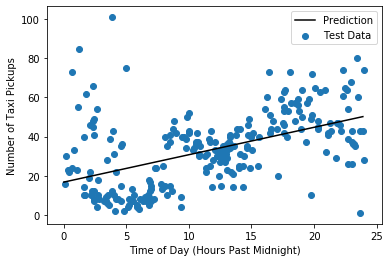

In [30]:
from sklearn.linear_model import LinearRegression
fitted_cab_model0 = LinearRegression().fit(X_train, y_train)
plot_cabs(fitted_cab_model0)

In [31]:
fitted_cab_model0.score(X_test, y_test)

0.240661535615741

We can see that there's still a lot of variation in cab pickups that's not being captured by a linear fit. Further, the linear fit is predicting massively more pickups at 11:59pm than at 12:00am. This is a bad property, and it's the conseqeuence of having a straight line with a non-zero slope. However, we can add columns to our data for $TimeMin^2$ and $TimeMin^3$ and so on, allowing a curvy polynomial line to hopefully fit the data better.

We'll be using ``sklearn``'s `PolynomialFeatures()` function to take some of the tedium out of building the expanded input data. In fact, if all we want is a formula like $y \approx \beta_0 + \beta_1 x + \beta_2 x^2 + ...$, it will directly return a new copy of the data in this format!

In [32]:
transformer_3 = PolynomialFeatures(3, include_bias=False)
expanded_train = transformer_3.fit_transform(X_train) # TRANSFORMS it to polynomial features
pd.DataFrame(expanded_train).describe() # notice that the columns now contain x, x^2, x^3 values

,0,1,2
count,1000.000000,1000.000000,1000.000000
mean,11.717217,182.833724,3234.000239
std,6.751751,167.225711,3801.801966
min,0.066667,0.004444,0.000296
25%,6.100000,37.210833,226.996222
50%,11.375000,129.390694,1471.820729
75%,17.437500,304.066458,5302.160684
max,23.966667,574.401111,13766.479963


A few notes on `PolynomialFeatures`:

- The interface is a bit strange. `PolynomialFeatures` is a _'transformer'_ in sklearn. We'll be using several transformers that learn a transformation on the training data, and then we will apply those transformations on future data. With PolynomialFeatures, the `.fit()` is pretty trivial, and we often fit and transform in one command, as seen above with ``.fit_transform()`.
- You rarely want to `include_bias` (a column of all 1's), since _**sklearn**_ will add it automatically. Remember, when using _**statsmodels,**_ you can just `.add_constant()` right before you fit the data.
- If you want polynomial features for a several different variables (i.e., multinomial regression), you should call `.fit_transform()` separately on each column and append all the results to a copy of the data (unless you also want interaction terms between the newly-created features). See `np.concatenate()` for joining arrays.

fitting expanded_train: [[6.73333333e+00 4.53377778e+01 3.05274370e+02]
 [2.18333333e+00 4.76694444e+00 1.04078287e+01]
 [1.41666667e+00 2.00694444e+00 2.84317130e+00]
 ...
 [1.96666667e+01 3.86777778e+02 7.60662963e+03]
 [1.17333333e+01 1.37671111e+02 1.61534104e+03]
 [1.42000000e+01 2.01640000e+02 2.86328800e+03]]


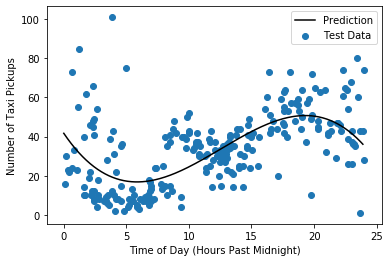

In [33]:
fitted_cab_model3 = LinearRegression().fit(expanded_train, y_train)
print("fitting expanded_train:", expanded_train)
plot_cabs(fitted_cab_model3, transformer_3)

<div class="exercise"><b>3.1</b></div>

**Questions**:
1. Calculate the polynomial model's $R^2$ performance on the test set. 
2. Does the polynomial model improve on the purely linear model?
3. Make a residual plot for the polynomial model. What does this plot tell us about the model?

In [34]:
# ANSWER 1
expanded_test = transformer_3.fit_transform(X_test)
print("Test R-squared:", fitted_cab_model3.score(expanded_test, y_test))
# NOTE 1: unlike statsmodels' r2_score() function, sklearn has a .score() function
# NOTE 2: fit_transform() is a nifty function that transforms the data, then fits it

Test R-squared: 0.3341251257077904


ANSWER 2: does it?

Yes, it appears to be an improvement since the curve (1) better approximates the general trend of the data and (2) the out-of-sample prediction is more accurate ($R^2_{test} = 0.334$ for the $3^{rd}$ order polynomial vs. 0.241 for the linear model).

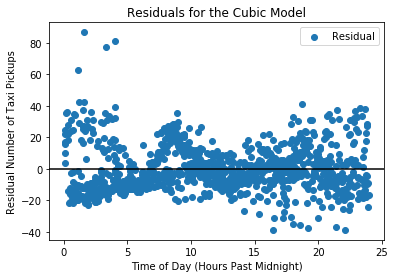

In [35]:
# ANSWER 3 (class discussion about the residuals)
x_matrix = transformer_3.fit_transform(X_train)

prediction = fitted_cab_model3.predict(x_matrix)
residual = y_train - prediction
plt.scatter(X_train, residual, label="Residual")
plt.axhline(0, color='k')

plt.title("Residuals for the Cubic Model")
plt.ylabel("Residual Number of Taxi Pickups")
plt.xlabel("Time of Day (Hours Past Midnight)")
plt.legend();

This plot shows that the pattern in the residuals is much better now: the non-linearities are at least improved or minimized.  There is still some signal here (non-constant variance) which may indicate that other predictors could be considered to capture this signal (why are there outliers at 1am to 5am in the morning?).

#### Other features
Polynomial features are not the only constucted features that help fit the data. Because these data have a 24 hour cycle, we may want to build features that follow such a cycle. For example, $sin(24\frac{x}{2\pi})$, $sin(12\frac{x}{2\pi})$, $sin(8\frac{x}{2\pi})$. Other feature transformations are appropriate to other types of data. For instance certain feature transformations have been developed for geographical data.

### Scaling Features
When using polynomials, we are explicitly trying to use the higher-order values for a given feature. However, sometimes these polynomial features can take on values that are drastically large, making it difficult for the system to learn an appropriate coefficients due to its large values and potentially large variance. To counter this, sometimes one may be interested in scaling the values for a given feature.

For our ongoing taxi-pickup example, using polynomial features improved our model. If we wished to scale the features, we could use `sklearn`'s StandardScaler() function:

In [36]:
# SCALES THE EXPANDED/POLY TRANSFORMED DATA
# we don't need to convert to a pandas dataframe, but it can be useful for scaling select columns
train_copy = pd.DataFrame(expanded_train.copy())
test_copy = pd.DataFrame(expanded_test.copy())

# Fit the scaler on the training data
scaler = StandardScaler().fit(train_copy)

# Scale both the test and training data. 
train_scaled = scaler.transform(expanded_train)
test_scaled = scaler.transform(expanded_test)

# we could optionally run a new regression model on this scaled data
fitted_scaled_cab = LinearRegression().fit(train_scaled, y_train)
fitted_scaled_cab.score(test_scaled, y_test)

0.3341251257077831

<hr style="height:3px">

## Part 4: Multiple regression and exploring the Football (aka soccer) data
Let's move on to a different dataset! The data imported below were scraped by [Shubham Maurya](https://www.kaggle.com/mauryashubham/english-premier-league-players-dataset/) and record various facts about players in the English Premier League. Our goal will be to fit models that predict the players' market value (how much would a team pay for their services), as estimated by https://www.transfermarkt.us.

`name`: Name of the player  
`club`: Club of the player  
`age` : Age of the player  
`position` : The usual position on the pitch  
`position_cat` :  1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers  
`market_value` : As on transfermrkt.com on July 20th, 2017 (in millions of dollars)  
`page_views` : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
`fpl_value` : Value in Fantasy Premier League as on July 20th, 2017  
`fpl_sel` : % of FPL players who have selected that player in their team  
`fpl_points` : FPL points accumulated over the previous season  
`region`: 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
`nationality`: Player's nationality  
`new_foreign`: Whether a new signing from a different league, for 2017/18 (till 20th July)  
`age_cat`: a categorical version of the Age feature  
`club_id`: a numerical version of the Club feature  
`big_club`: Whether one of the Top 6 clubs  
`new_signing`: Whether a new signing for 2017/18 (till 20th July)  

As always, we first import, verify, split, and explore the data.

## Import and verification and grouping

In [37]:
league_df = pd.read_csv("data/league_data.csv")
print(league_df.dtypes)

# QUESTION: what would you guess is the mean age? mean salary?
#league_df.head()

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel          object
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object


In [38]:
league_df.shape

(461, 17)

In [39]:
league_df.describe()

,age,position_cat,market_value,page_views,fpl_value,fpl_points,region,new_foreign,age_cat,club_id,big_club,new_signing
count,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,460.000000,461.000000,461.000000,461.000000,461.000000,461.000000
mean,26.804772,2.180043,11.012039,763.776573,5.447939,57.314534,1.993478,0.034707,3.206074,10.334056,0.303688,0.145336
std,3.961892,1.000061,12.257403,931.805757,1.346695,53.113811,0.957689,0.183236,1.279795,5.726475,0.460349,0.352822
min,17.000000,1.000000,0.050000,3.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,24.000000,1.000000,3.000000,220.000000,4.500000,5.000000,1.000000,0.000000,2.000000,6.000000,0.000000,0.000000
50%,27.000000,2.000000,7.000000,460.000000,5.000000,51.000000,2.000000,0.000000,3.000000,10.000000,0.000000,0.000000
75%,30.000000,3.000000,15.000000,896.000000,5.500000,94.000000,2.000000,0.000000,4.000000,15.000000,1.000000,0.000000
max,38.000000,4.000000,75.000000,7664.000000,12.500000,264.000000,4.000000,1.000000,6.000000,20.000000,1.000000,1.000000


### (Stratified) train/test split
We want to make sure that the training and test data have appropriate representation of each region; it would be bad for the training data to entirely miss a region. This is especially important because some regions are rather rare.

<div class="exercise"><b>4.1</b></div>

**Questions**:
1. Use the `train_test_split()` function, while (a) ensuring the test size is 20% of the data, and; (2) using 'stratify' argument to split the data (look up documentation online), keeping equal representation of each region. This doesn't work by default, correct? What is the issue?
2. Deal with the issue you encountered above. Hint: you may find numpy's `.isnan()` and panda's `.dropna()` functions useful!
3. How did you deal with the error generated by `train_test_split`? How did you justify your action? 

*your answer here*:


In [40]:
# Your code
league_df_old = league_df.copy()

try:
    
    # Doesn't work: a value is missing
    train_data, test_data = train_test_split(league_df, test_size = 0.2, stratify=league_df['region'], random_state=109)
except:
    
    # Count the missing lines and drop them
    missing_rows = np.isnan(league_df['region'])
    print("Uh oh, {} lines missing data! Dropping them".format(np.sum(missing_rows)))
    league_df = league_df.dropna(subset=['region'])
    train_data, test_data = train_test_split(league_df, test_size = 0.2, stratify=league_df['region'], random_state=109)

Uh oh, 1 lines missing data! Dropping them


In [41]:
# here's the observation we dropped:

league_df_old[league_df_old['region'].isna()]

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
188,Steve Mounie,Huddersfield,22,CF,1,5.5,56,6.0,0.60%,0,NaN,Benin,0,2,8,0,0


In [42]:
train_data.shape, test_data.shape

((368, 17), (92, 17))

Now that we won't be peeking at the test set, let's explore and look for patterns! We'll introduce a number of useful pandas and numpy functions along the way. 

### Groupby
Pandas' `.groupby()` function is a wonderful tool for data analysis. It allows us to analyze each of several subgroups.

Many times, `.groupby()` is combined with `.agg()` to get a summary statistic for each subgroup. For instance: What is the average market value, median page views, and maximum fpl for each player position?

In [43]:
train_data.groupby('position').agg({
    'market_value': np.mean,
    'page_views': np.median,
    'fpl_points': np.max
})

,market_value,page_views,fpl_points
position,,,
AM,27.446429,995.5,218
CB,9.215441,327.5,178
CF,13.778409,745.0,224
CM,11.047170,416.0,225
DM,12.480000,338.0,131
GK,7.377778,419.0,149
LB,9.268519,380.0,177
LM,3.500000,279.5,99
LW,13.718333,470.5,264


In [44]:
train_data.position.unique()

array(['CB', 'GK', 'DM', 'AM', 'CM', 'RB', 'LW', 'LM', 'CF', 'RW', 'LB',
       'RM', 'SS'], dtype=object)

In [45]:
train_data.groupby(['big_club', 'position']).agg({
    'market_value': np.mean,
    'page_views': np.mean,
    'fpl_points': np.mean
})

market_value   page_views  fpl_points
big_club position                                       
0        AM           13.464286   475.857143   56.714286
         CB            4.177174   273.760870   42.500000
         CF            9.007812   784.531250   51.218750
         CM            5.910256   347.512821   36.871795
         DM            7.750000   447.000000   42.111111
         GK            3.869565   318.565217   54.695652
         LB            5.539474   264.894737   53.368421
         LM            3.500000   349.500000   40.833333
         LW            6.450000   411.550000   42.450000
         RB            4.773810   293.857143   49.571429
         RM            4.333333   280.333333    1.666667
         RW            8.880435   611.130435   59.000000
         SS            4.625000   784.500000   58.250000
1        AM           41.428571  2590.714286  152.714286
         CB           19.750000   958.409091   70.500000
         CF           26.500000  2200.250000   90.083333
         CM           25.357143  1940.500000   80.928571
         DM           24.642857  1545.714286   71.714286
         GK           13.584615   859.461538   67.076923
         LB           18.125000   962.125000   77.125000
         LW           28.255000  2068.400000   97.100000
         RB           20.416667   834.333333  104.333333
         RM           20.000000  2028.000000   94.000000
         RW           30.000000  1324.166667   71.000000

<hr style="height:3px">

## Part 3.2: Linear regression on the football data
This section of the lab focuses on fitting a model to the football (soccer) data and interpreting the model results. The model we'll use is

$$\text{market_value} \approx \beta_0 + \beta_1\text{fpl_points} + \beta_2\text{age} + \beta_3\text{age}^2 + \beta_4log_2\left(\text{page_views}\right) + \beta_5\text{new_signing} +\beta_6\text{big_club} + \beta_7\text{position_cat}$$

We're including a 2nd degree polynomial in age because we expect pay to increase as a player gains experience, but then decrease as they continue aging. We're taking the log of page views because they have such a large, skewed range and the transformed variable will have fewer outliers that could bias the line. We choose the base of the log to be 2 just to make interpretation cleaner.

<div class="exercise"><b>4.2</b></div>

**Questions**:
1. Build the data and fit this model to it. How good is the overall model?


In [46]:
# Q1: we'll do most of it for you ...
y_train = train_data['market_value']
y_test = test_data['market_value']
def build_football_data(df):
    x_matrix = df[['fpl_points','age','new_signing','big_club','position_cat']].copy()
    x_matrix['log_views'] = np.log2(df['page_views'])
    
    # CREATES THE AGE SQUARED COLUMN
    x_matrix['age_squared'] = df['age']**2
    
    # OPTIONALLY WRITE CODE to adjust the ordering of the columns, just so that it corresponds with the equation above
    x_matrix = x_matrix[['fpl_points','age','age_squared','log_views','new_signing','big_club','position_cat']]
    
    # add a constant
    x_matrix = sm.add_constant(x_matrix)
    
    return x_matrix

# use build_football_data() to transform both the train_data and test_data
train_transformed = build_football_data(train_data)
test_transformed = build_football_data(test_data)

fitted_model_1 = OLS(endog= y_train, exog=train_transformed, hasconst=True).fit()
fitted_model_1.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           market_value   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     120.7
Date:                Fri, 02 Jul 2021   Prob (F-statistic):           1.97e-90
Time:                        11:08:18   Log-Likelihood:                -1237.3
No. Observations:                 368   AIC:                             2491.
Df Residuals:                     360   BIC:                             2522.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -81.9777     13.790     -5.945      0.000    -109.096     -54.859
fpl_points       0.0888      0.009     10.014      0.000       0.071       0.106
age              5.7471      0.981      5.861      0.000       3.819       7.676
age_squared     -0.1135      0.018     -6.325      0.000      -0.149      -0.078
log_views        1.9162      0.388      4.941      0.000       1.154       2.679
new_signing      0.8544      1.028      0.831      0.407      -1.168       2.876
big_club         9.7805      1.063      9.203      0.000       7.691      11.870
position_cat    -1.0690      0.415     -2.576      0.010      -1.885      -0.253
==============================================================================
Omnibus:                      114.110   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.828
Skew:                           1.268   Prob(JB):                    3.94e-110
Kurtosis:                       8.141   Cond. No.                     2.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
# WRITE CODE TO RUN r2_score(), then answer the above question about the overall goodness of the model


r2_score(y_test,fitted_model_1.predict(test_transformed))

0.5111867140012912

Note: $R^2$ here illustrates the typical pattern: the model performs a little worse on the test set than the train set ($R^2=0.511$ in the test vs. $R^2=0.701$ in the train, a roughly 27% worse job in test).

<div class="exercise"><b>4.3</b></div>
 Interpret the regression model. What is the meaning of the coefficient for:

- age and age$^2$
    
- $log_2($page_views$)$
    
- big_club

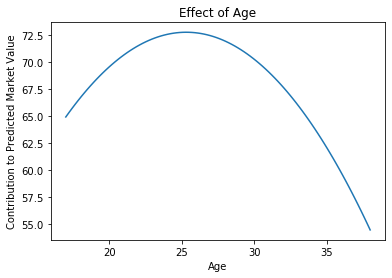

In [48]:

#Your code here

fitted_model_1 = OLS(endog= y_train, exog=train_transformed, hasconst=True).fit()
fitted_model_1.summary()



# Q2: let's use the age coefficients to show the effect of age has on one's market value;
# we can get the age and age^2 coefficients via:
agecoef = fitted_model_1.params.age
age2coef = fitted_model_1.params.age_squared

# let's set our x-axis (corresponding to age) to be a wide range from -100 to 100, 
# just to see a grand picture of the function
x_vals = np.linspace(np.min(train_data['age']),np.max(train_data['age']),100)
y_vals = agecoef*x_vals +age2coef*x_vals**2

# WRITE CODE TO PLOT x_vals vs y_vals
plt.plot(x_vals, y_vals)
plt.title("Effect of Age")
plt.xlabel("Age")
plt.ylabel("Contribution to Predicted Market Value")
plt.show()

# Q2A: WHAT HAPPENS IF WE USED ONLY AGE (not AGE^2) in our model (what's the r2?); make the same plot of age vs market value
# Q2B: WHAT HAPPENS IF WE USED ONLY AGE^2 (not age) in our model (what's the r2?); make the same plot of age^2 vs market value
# Q2C: PLOT page views vs market value


The plot above illustrates how age and age$^2$ relate to the market value in tandem (difficult to interpret separately): market value peaks at an age around 25-26 years old, and is much lower at older ages (in the thirties) or younger ages (in teens or early twenties). This makes sense since the linear effect of age is positive (so starts out increasing for small positive values of age) and the quadratic effect is negative (which starts to dominate the relationship and make it negative at higher values of age).  This relationship is after controlling for the other predictors in the model.

The coefficient for $log_2$(page_views) is 1.916, which means a doubling in page_views is associated with a 1.916 unit increase (millions of dollars) in market value, controlling for the other predictors in the model.  And signing with a big_club is associatecd with a 9.78 unit increase in market value vs. signing with a non-big_club, after controlling for the other factors in the model.

<div class="exercise"><b>4.4</b></div>
What should a player do in order to improve their market value? How many page views should a player go get to increase their market value by 10?

Assuming one cannot control the age at which they hit the market (hitting it at age 25 or 26 would be ideal), this model suggests a player can increase their market value by playing for a big_club, have a greater media presence, and be a more productive fantasy player.  Position is also important, but is difficult to interpret this variable since it should be treated as a set of binary indicators (3 binary indiciators for the 4 categories) instead of a single quantitative predictor.

<hr style='height:3px'>

### Part 4.3: Turning Categorical Variables into multiple binary variables
Of course, we have an error in how we've included player position. Even though the variable is numeric (1,2,3,4) and the model runs without issue, the value we're getting back is garbage. The interpretation, such as it is, is that there is an equal effect of moving from position category 1 to 2, from 2 to 3, and from 3 to 4, and that this effect is probably between -0.5 to -1 (depending on your run).

In reality, we don't expect moving from one position category to another to be equivalent, nor for a move from category 1 to category 3 to be twice as important as a move from category 1 to category 2. We need to introduce better features to model this variable.

We'll use `pd.get_dummies` to do the work for us.

In [49]:
train_design_recoded = pd.get_dummies(train_transformed, columns=['position_cat'], drop_first=True)
test_design_recoded = pd.get_dummies(test_transformed, columns=['position_cat'], drop_first=True)

train_design_recoded.head()

,const,fpl_points,age,age_squared,log_views,new_signing,big_club,position_cat_2,position_cat_3,position_cat_4
138,1.0,113,24,576,10.411511,0,0,0,1,0
250,1.0,73,34,1156,8.768184,1,1,0,0,1
291,1.0,0,25,625,8.049849,0,0,0,1,0
31,1.0,120,37,1369,8.768184,0,0,0,0,1
337,1.0,62,33,1089,7.507795,0,0,1,0,0


We've removed the original `position_cat` column and created three new ones.


<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. If we're fitting a model without a constant, should we have three dummy columns or four dummy columns?
2. Fit a model on the new, recoded data, then interpret the coefficients related to `position_cat`.



In [50]:
# Your code
### SOLUTION:
resu = OLS(y_train, train_design_recoded).fit()
resu.summary()
print("r2:", r2_score(y_test, resu.predict(test_design_recoded)))
print("position_cat_2 coef:", resu.params.position_cat_2)
print("position_cat_3 coef:", resu.params.position_cat_3)
print("position_cat_4 coef:", resu.params.position_cat_4)
train_design_recoded.shape, y_train.shape

r2: 0.5002232479449644
position_cat_2 coef: -0.039688647311728664
position_cat_3 coef: -2.101410351781797
position_cat_4 coef: -2.9727220867964896


((368, 10), (368,))

**Answers**:

Pandas allows us to drop the first category because it will serve as the reference group in the regression (sort of can be though of as the intercept *absorbing* this group).  

1. If there is no intercept, then we should fully include all four dummy indicators as predictors (to estimate the 4 groups separately, rather than 3 groups in comparison to the reference group).

2. The output below estimates the coefficient for `position_cat_2` to be -1.05: which suggests that midfielders are valued about 1 unit below attackers, on average (holding the other predictors constant when comparing these two groups).


## BONUS EXERCISE:
We have provided a spreadsheet of Boston housing prices (data/boston_housing.csv). The 14 columns are as follows:
1. CRIM: per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to ﬁve Boston employment centers
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per \$10,000
11. PTRATIO: pupil-teacher ratio by town
12. B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town
13. LSTAT: % lower status of the population
14. MEDV: Median value of owner-occupied homes in $1000s We can see that the input attributes have a mixture of units

There are 450 observations.
<div class="exercise"><b>Exercise</b></div>

Using the above file, try your best to predict **housing prices (the 14th column).** We have provided a test set `data/boston_housing_test.csv` but refrain from looking at the file or evaluating on it until you have finalized and trained a model.
1. Load in the data (be careful: it is tab-delimited). Quickly look at a summary of the data to familiarize yourself with it and ensure nothing is too egregious.
2. Use a previously-discussed function to automatically partition the data into a training and validation (aka development) set. It is up to you to choose how large these two portions should be.
3. Train a basic model on just a subset of the features. What is the performance on the validation set?
4. Train a basic model on all of the features. What is the performance on the validation set?
5. Toy with the model until you feel your results are reasonably good.
6. Perform cross-validation with said model, and measure the average performance. Are the results what you expected? Were the average results better or worse than that from your original 1 validation set?
7. Experiment with other models, and for each, perform 10-fold cross-validation. Which model yields the best average performance? Select this as your final model.
8. Use this model to evaulate your performance on the testing set. What is your performance (MSE)? Is this what you expected?